In [1]:
import glicko2 as Glicko

In [2]:
# improbable results are likely so set tau low
tau = 0.2
phi = 350
sigma = 0.15
mu_decay_factor = 0.995

In [3]:
glck = Glicko.Glicko2(tau=tau, phi=phi, sigma=sigma)

In [4]:
import pandas as pd
import math
import numpy as np

In [5]:
naf_data = pd.read_csv("data/NAF_games.csv.gz", sep=",", 
                       parse_dates=['date'], index_col=3)

naf_data.sort_values("date", inplace=True)

In [6]:
naf_data.head()

,tournamentname,tournamentnation,tournamentcity,HomeCoachNAFname,HomeCoachNAFid,HomeRace,goalshome,AwayCoachNAFname,AwayCoachNAFid,AwayRace,goalsaway,date
gameid,,,,,,,,,,,,
8572,The Dutch Open 2003,Netherlands,Amsterdam,Gorbad,152,Wood Elves,1,dolferl,126,Dark Elves,5,2003-01-02 12:00:00
8571,The Dutch Open 2003,Netherlands,Amsterdam,Norse,144,Dwarves,2,Skevan,136,Norse,0,2003-01-02 12:00:00
8557,The Dutch Open 2003,Netherlands,Amsterdam,playfulhands,148,Wood Elves,3,grep_v,142,Chaos Dwarves,2,2003-01-02 12:00:00
8558,The Dutch Open 2003,Netherlands,Amsterdam,madhobbit,130,Undead,1,Zy_Nox,86,Undead,1,2003-01-02 12:00:00
8559,The Dutch Open 2003,Netherlands,Amsterdam,Longshot,101,Wood Elves,3,Redfang,143,Dwarves,1,2003-01-02 12:00:00


In [7]:
home = naf_data[["HomeCoachNAFid", "HomeCoachNAFname"]].drop_duplicates()
away = naf_data[["AwayCoachNAFid", "AwayCoachNAFname"]].drop_duplicates()
away.columns = home.columns

In [8]:
# create lookup table to map id to name
dd = pd.concat([home, away], axis=0)
dd = dd.set_index("HomeCoachNAFid")

In [9]:
lookup = dd.to_dict()["HomeCoachNAFname"]

In [10]:
ranking_periods = pd.date_range(naf_data.iloc[0].date - pd.offsets.MonthBegin(1), 
                                naf_data.iloc[-1].date + pd.offsets.MonthBegin(1), 
                                freq='2M')

In [11]:
race_ids = sorted(naf_data.HomeRace.unique())

In [12]:
class Player(object):
    
    # need to maintain only historical rankings, not phi etc.
    def __init__(self, player_id):
        
        self.pid = player_id
        self.rankings = {}
        self.new_rankings = {}
        self.hist_ratings = pd.DataFrame(columns=race_ids)
        self.name = lookup[player_id]
        
    def get_ranking(self, race_id):
        
        assert race_id in self.hist_ratings.columns, "bad race_id"
        return self.rankings.get(race_id, glck.create_rating())
        
    def update_rankings(self, games_df):
        
        byrace = games_df.groupby("HomeRace")
        for played_race in byrace.groups:

            games = byrace.get_group(played_race)
            series = list()

            for opp_id, opp_race, result in zip(games.AwayCoachNAFid, 
                                                games.AwayRace, 
                                                games.result):

                series.append((result,
                               ranking_data[opp_id].get_ranking(opp_race)))

            my_ranking = self.get_ranking(played_race)
            
            self.new_rankings[played_race] = glck.rate(my_ranking, series)

    # now through all players: if not played then increment their phi
    
    def end_ranking_period(self, date):
        
        # copy new rankings
        for race in self.hist_ratings.columns:
            if (race in self.rankings) and (race not in self.new_rankings):
                self.rankings[race] = self.decay(race)
            elif race in self.new_rankings:
                self.rankings[race] = self.new_rankings[race]
                
        # delete temp ranks
        self.new_rankings = {}
        
        # fill historical with rankings.
        self.hist_ratings.loc[date] = [self.rate(c) for c in self.hist_ratings.columns]
        
    def rate(self, race):
        
        if race not in self.rankings:
            return np.nan
        
        else:
            q = self.rankings[race]
            return q.mu - 2 * q.phi
        
    def decay(self, race):
        # transform into glicko space...
        dnp = glck.scale_down(self.rankings[race])
        
        # increment phi
        phi_star = math.sqrt(dnp.phi ** 2 + dnp.sigma ** 2)
                
        # shrink mu
        mu_star = dnp.mu * mu_decay_factor
                
        return glck.scale_up(
            glck.create_rating(mu=mu_star, phi=phi_star, sigma=dnp.sigma))

In [13]:
ranking_data = dict()

for start, stop in zip(ranking_periods[:-1], ranking_periods[1:]):
    
    new_ranking = dict()
    
    start_ix = naf_data.date.searchsorted(start)[0]
    stop_ix = naf_data.date.searchsorted(stop)[0]
    
    # extract just games in this period
    d = naf_data[start_ix:stop_ix]
    
    # drop irrelevent fields
    x = d.drop(["tournamentname", "tournamentnation", "tournamentcity", 
                "HomeCoachNAFname", "AwayCoachNAFname", "date"], axis=1).copy()
    
    # duplicate- as we have to handle both players
    y = x.ix[:, [3, 4, 5, 0, 1, 2]].copy()
    y.columns = x.columns
    x = pd.concat([x, y], axis=0)

    # create new result column
    x["result"] = np.where(x.goalshome > x.goalsaway, 1, 
                           np.where(x.goalshome < x.goalsaway, 0, 0.5)) 
    
    for xid in x.HomeCoachNAFid.unique():
        if xid not in ranking_data:
            ranking_data[xid] = Player(xid)
    
    # group by player
    grped = x.groupby("HomeCoachNAFid")
    
    # first run through all players who have played in this period
    for player in grped.groups:
        
        new_ranking[player] = dict()
        
        # all games played by player X
        data = grped.get_group(player)    
        ranking_data[player].update_rankings(data)
        
    # end all ranking periods.
    for k, v in ranking_data.items():
        v.end_ranking_period(stop)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
current_ratings = {}

for key, value in ranking_data.items():
    if value.name is np.nan:
        continue
    current_ratings[value.name] = value.hist_ratings.loc[stop]
    
df_current_ratings = pd.DataFrame(pd.concat(current_ratings, names=["coach", "race"]))
df_current_ratings.columns = ["rating"]

In [16]:
df_current_ratings = df_current_ratings[~np.isnan(df_current_ratings.rating)]

In [17]:
df_current_ratings = df_current_ratings.sort_values("rating", ascending=False)

In [18]:
df_current_ratings[:30]

,,rating
coach,race,
Pipey,Norse,1693.768881
Tank,Wood Elves,1693.144317
Purplegoo,Humans,1688.672869
Pipey,Undead,1686.489418
Joemanji,Lizardmen,1686.169053
Purplegoo,Vampires,1680.273681
Karaak,Lizardmen,1674.686044
AndyDavo,Dark Elves,1674.553959
zoul,Dark Elves,1673.099108


## Parse data structure into something more tabular

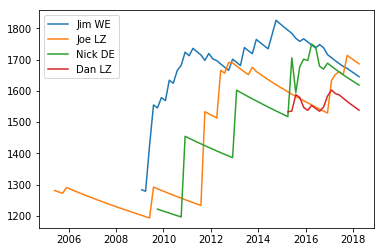

In [20]:
fig, ax = plt.subplots()

ax.plot(ranking_data[12403].hist_ratings["Wood Elves"], label="Jim WE")
ax.plot(ranking_data[3312].hist_ratings["Lizardmen"], label="Joe LZ")
ax.plot(ranking_data[13409].hist_ratings["Dark Elves"], label="Nick DE")
ax.plot(ranking_data[20556].hist_ratings["Lizardmen"], label="Dan LZ")
ax.legend()

In [21]:
import seaborn as sns

In [22]:
%matplotlib inline

/home/njh/miniconda3/envs/science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


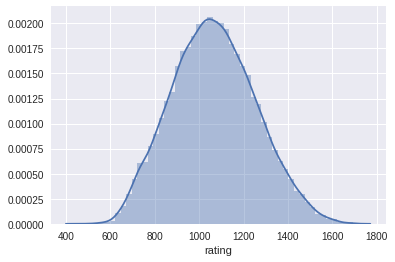

In [23]:
sns.distplot(df_current_ratings.rating)

In [ ]:
# algorithm:

# grab data in rating period. 2 months.

# reshape the data so 2 x the number of rows and home/away repeated. column for w/l/d
# 3 columns, playerID, oppoent, result

# group df by playerA id. 

# create a matrix of all the players who compet

